# Bitbot

## Jupyter notebook setup

In [6]:
# This allows multiple outputs from a single jupyter notebook cell:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [7]:
%matplotlib inline
import pandas as pd
from src.bitbot import BitBot
import sys
!{sys.executable} -m pip install ccxt mplfinance yfinance
import ccxt
import mplfinance as mpf
from matplotlib.pyplot import imshow
import yfinance
import pathlib
import os
from src.configuration.bitbot_files import use_config_dir
from src.configuration.bitbot_config import load_config_ini

## Prep chart data

Load config files

In [8]:
curdir = pathlib.Path(os.path.abspath('')).resolve()
files = use_config_dir(curdir)
config = load_config_ini(files)
config.set('display', 'output', 'disk')

Convert candle data to pandas

In [9]:
data_frame = pd.DataFrame(
    chart_data.candle_data,
    columns=['date', 'open', 'high', 'low', 'close', 'volume'])
    
data_frame.index = pd.DatetimeIndex(data_frame['date'])

Fetch candle data

## Display Bitbot overlaid chart 

Fetch exchange data

In [10]:
# fetch configured price history
from src.exchanges import crypto_exchanges
exchange = crypto_exchanges.Exchange(config)
chart_data = exchange.fetch_history()

Run Bitbot chart

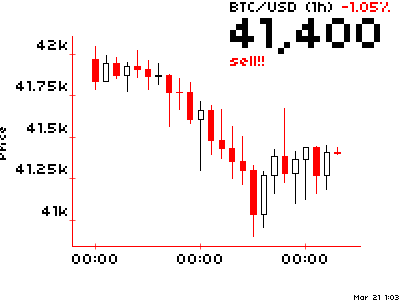

In [32]:
app = BitBot(config, files)
img  = app.display_chart()
img.show()

#### Display Bitbot MPF plot

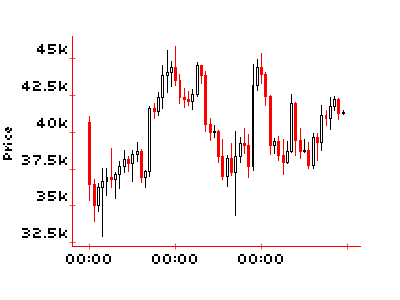

In [28]:
from src.drawing.market_chart import MarketChart
from src.display.picker import picker as display_picker
from PIL import Image
import io

display = display_picker(config)
chart = MarketChart(config, display, files)

with io.BytesIO() as file_stream:
    chart.create_plot(chart_data).write_to_stream(file_stream)
    chart_image = Image.open(file_stream)
    chart_image.show()

## CCXT

### Load Exchange and markets

In [11]:
exchange = getattr(ccxt, 'bitmex')({ 
    #'apiKey': '<YOUR API KEY HERE>',
    #'secret': '<YOUR API SECRET HERE>',
    'enableRateLimit': True,
})
mkts = exchange.loadMarkets()

In [12]:
exchange_data = exchange.fetchOHLCV('BTC/USD', '5m', limit=60)
df = pd.DataFrame(exchange_data)
df.columns = ["Date", "Open", "Low", "High", "Close", "Volume"]
df['Date'] = df['Date'].astype('datetime64[ms]')
df.index = pd.DatetimeIndex(df["Date"])
df.head(3)

,Date,Open,Low,High,Close,Volume
Date,,,,,,
2022-03-21 14:45:00,2022-03-21 14:45:00,40823.5,40899.0,40784.0,40863.5,5001000.0
2022-03-21 14:50:00,2022-03-21 14:50:00,40863.5,40941.0,40867.0,40941.0,1564500.0
2022-03-21 14:55:00,2022-03-21 14:55:00,40941.0,41059.0,40913.5,41019.0,7384800.0


Text(0, 0.5, '')

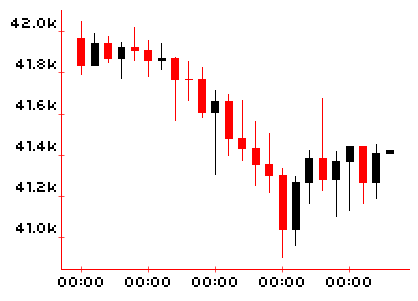

In [271]:
from matplotlib.ticker import EngFormatter
import matplotlib.pyplot as plt
mc = mpf.make_marketcolors(
    alpha=1.0,
    up='black', down='red',
    edge={'up': 'black', 'down': 'red'},  # 'none',
    wick={'up': 'black', 'down': 'red'},
    volume={'up': 'black', 'down': 'red'})
rc = {
    # "axes.xmargin": 0.1,
    # "axes.ymargin": 0.1,
    "axes.autolimit_mode": "round_numbers",
    #"axes.autoscale": "true",
    #'figure.constrained_layout.use': True
}
s = mpf.make_mpf_style(
    marketcolors=mc,
    base_mpl_style=files.base_style,
    mavcolors=['#1f77b4', '#ff7f0e', '#2ca02c'],
    rc=rc
)
display = display_picker(config)
display_width, display_height = display.size()
figsize = (display_width / 100, display_height / 100)

fig, ax = mpf.plot(
    data_frame,
    scale_width_adjustment=dict(volume=0.4, candle=0.8, lines=0.5),
    update_width_config=dict(candle_linewidth=0.5),
    returnfig=True,
    type='candle',
    # mav=(10, 20),
    style=s,
    tight_layout=True,
    figsize=figsize,
    xrotation=0,
)
ax[0].autoscale(enable=True, axis="x", tight=True)
ax[0].autoscale(enable=True, axis="y", tight=True)
ax[0].set_ylabel("")
ax[0].yaxis.set_major_formatter(EngFormatter(sep='',places=1))
ax[0].margins(0.05, 0.05)
fig